## Calculations for techno-economic overview
### Tips:
[How to use `pint` with packages requiring `simpler data types](https://pint.readthedocs.io/en/stable/wrapping.html)  
  
### Ideas:
- Possible Scenario: Netzentgelt is removed  
## Import packages and define additional units and WWTP-specific conditions

## Initialize Operator and CHPs

In [1]:
from import_setup import *
from electrolysis import *
from methanation import *
from wwtp import *


# TODO: in the future, these variables can also be handled by a separate function/script
# for easier handling, different dataframes are created for the most needed quantities
# for type safety, the variables extracted from df are all specified as float arrays
# variables that are written into a new line every timestep
time_arr = df["Time / h"].values.astype(float)
time_diff = df["Time_diff / h"].values.astype(float)
raw_price = df["Price / EURO/MWh"].values.astype(float)
gas_production = df["Gas Production / Nm^3/h"].values.astype(float)
heat_demand_fermenter = df["Fermenter Heat Demand / kW"].values.astype(float)
chp_run_time = np.ones((time_arr.shape[0], num_chps))
chp_load = np.zeros((time_arr.shape[0], num_chps))
chp_el_power = np.zeros((time_arr.shape[0], num_chps))
chp_th_power = np.zeros((time_arr.shape[0], num_chps))
chp_gas_consumption = np.zeros((time_arr.shape[0], num_chps))
maintenance = np.zeros((time_arr.shape[0], num_chps))
maintenance_time_per_rule = np.zeros((time_arr.shape[0], num_chps, num_maintenance_rules))
gas_storage = np.zeros(time_arr.shape)
flare_run_time = np.zeros(time_arr.shape[0])
flare_gas_consumption = np.zeros(time_arr.shape[0])
temp_heat_net = np.zeros(time_arr.shape[0])
boiler_load = np.zeros((time_arr.shape[0], num_boilers))
boiler_th_power = np.zeros((time_arr.shape[0], num_boilers))
boiler_run_time = np.zeros((time_arr.shape[0], num_boilers))
boiler_gas_consumption = np.zeros((time_arr.shape[0], num_boilers))

# variables that are overwritten every timestep
run_time_between_maintenance = np.zeros([num_chps, chp_maintenance_rules.shape[1]], dtype=float)
maintenance_remaining_failure = np.zeros(num_chps, dtype=float)



# initialize operator
from load_scheduler import *
operator = LoadScheduler(flare_threshold, chp_gas_storage_rules, chp_maintenance_rules, chps, boilers, heat_net, price_threshold=80)
gas_storage[0] = 2402.79 # Nm^3
temp_heat_net[0] = 70 # °C


## Now do the loop

In [2]:
logging.debug("Starting simulation")
# Start the stopwatch
tic = time.time()

for k in range(1, len(time_arr)):
    # old_run_time=np.array([1,1]), old_maintenance=np.array([0,0]), old_gas_storage=1200, new_time_diff=1, new_price=0.1
    # run scheduler
    logging.debug("now calculating timestep: " + str(k))

    # calculate new temperature of heat network based on heat demand of fermenter
    temp_heat_net[k] = heat_net.new_temperature(heat_demand_fermenter[0],temp_heat_net[k-1],mass_flow_heat_net)
    # schedule runnning of chps and flare (and boilers)
    chp_run_time[k,:], maintenance[k,:], chp_load[k,:], maintenance_time_per_rule[k,:], _, _, _,\
        run_time_between_maintenance, boiler_load[k,:], boiler_run_time[k,:], flare_run_time[k], flare_gas_consumption[k] = \
        operator.schedule_production(chp_run_time[k-1,:], maintenance[k-1,:],gas_storage[k-1], time_diff[k], raw_price[k], maintenance_remaining_failure, flare_run_time[k-1], boiler_run_time[k-1,:], temp_heat_net[k], mass_flow_heat_net, 80)
    # run CHPs
    for i in range(num_chps):
        chp_load[k,i], chp_el_power[k,i], chp_th_power[k,i], chp_gas_consumption[k,i], maintenance_remaining_failure[i], chp_run_time[k,:] = \
                chps[i].run(chp_load[k,i], run_time_between_maintenance[i,:], maintenance_remaining_failure[i], chp_run_time[k,:], time_diff[k], biogas["h_u"])
    # run flare
    flare_gas_consumption[k] = flare.run(flare_gas_consumption[k])

    # run Boilers
    for i in range(num_boilers):
        boiler_load[k,i], boiler_th_power[k,i], boiler_gas_consumption[k,i], boiler_run_time[k,i] = \
            boilers[i].run(boiler_load[k,i], boiler_run_time[k,i], time_diff[k], biogas["h_u"])
    
    # calculate new temperature of heat network based on heat demand of fermenter
    temp_heat_net[k] = heat_net.new_temperature(np.sum(boiler_th_power[k,:])+np.sum(chp_th_power[k,:]),temp_heat_net[k-1],mass_flow_heat_net)

    # calculate new gas storage.
    # TODO: For now, the gas storage can be computed in main. If future complexity is coming in (if some costs are associated with it etc...) the gas storage needs to be separated into another object
    gas_storage[k] = gas_storage[k-1] + (gas_production[k] - chp_gas_consumption[k,:].sum() - flare_gas_consumption[k]) * time_diff[k] # in Nm^3

    # every 1000 timesteps, print the current timestep as info log level
    if k % 10000 == 0:
        logging.info("timestep: " + str(k) + " of " + str(len(time_arr)))

    # For debugging, print a timestep near the problem to stop sim there
    if time_arr[k] == 7100*3:
        logging.debug("timestep: " + str(k) + " of " + str(len(time_arr)))

# Stop the stopwatch
toc = time.time()

logging.info('Simulation took {:3.2f}s to compute, with {} steps'.format(toc-tic, len(time_arr)))


INFO:root:timestep: 10000 of 35044
INFO:root:timestep: 20000 of 35044
INFO:root:timestep: 30000 of 35044
INFO:root:Simulation took 25.30s to compute, with 35044 steps


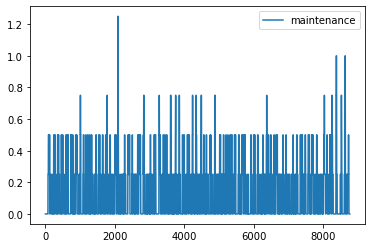

In [8]:
import matplotlib.pyplot as plt
# %matplotlib widget
# plt.plot(raw_price[:])
# plt.plot(time_arr, chp_run_time.sum(axis=1), label="running")
plt.plot(time_arr[1:], np.diff(maintenance.sum(axis=1)), label="maintenance")
# plt.plot(time_arr, gas_storage[:], label="gas storage")
# plt.plot(time_arr, chp_el_power.sum(axis=1), label="chp_el_power")
# plt.plot(time_arr, chp_th_power.sum(axis=1), label="chp_th_power")
# plt.plot(time_arr, gas_production[:], label="gas_production")
# plt.plot(time_arr, chp_gas_consumption.sum(axis=1), label="chp_gas_consumption")
# plt.plot(time_arr, flare_gas_consumption, label="flare_gas_consumption")
# plt.plot(time_arr, chp_load[:,0], label="chp_load")
plt.legend()

### Roll through Array

## Benchmark of different DataFrame-Conversions
Note: Pint arrays should always use only one quantity!

In [ ]:
ar = df[["Time", "Price"]].values

tic1 = time.time()

b = ar[:,0] * ar[:,1]

# Stop the stopwatch
toc1 = time.time()

print('All-in-one-NumPy-array took {:3.2f}s to compute'.format(toc1-tic1))


ar1 = df["Time"].values
ar2 = df["Price"].values

tic1 = time.time()

b = ar1 * ar2

# Stop the stopwatch
toc1 = time.time()

print('Separate PintArrays took {:3.2f}s to compute'.format(toc1-tic1))


ar3 = df["Time"].values.quantity
ar4 = df["Price"].values.quantity

tic1 = time.time()

b = ar3 * ar4

# Stop the stopwatch
toc1 = time.time()

print('Separate Quantitys took {:3.2f}s to compute'.format(toc1-tic1))


c:\Users\BuB\.conda\envs\env_v1\lib\site-packages\pint_pandas\pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


All-in-one-NumPy-array took 0.30s to compute
Separate PintArrays took 0.01s to compute
Separate Quantitys took 0.00s to compute


In [ ]:
from numba import njit

@njit
def test_numba(a,b):
    return a*b

test_numba(ar3,ar4)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\BuB\AppData\Local\Temp\ipykernel_10272\3502055945.py (5)[0m
[1m
File "..\..\..\..\..\..\..\AppData\Local\Temp\ipykernel_10272\3502055945.py", line 5:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'pint.quantity.build_quantity_class.<locals>.Quantity'>[0m
- argument 1: [1mCannot determine Numba type of <class 'pint.quantity.build_quantity_class.<locals>.Quantity'>[0m
